In [1]:
import os
import ray
import time
import math
import numpy as np
import pandas as pd
from ray import tune
import seaborn as sns
from typing import Any
import gymnasium as gym
from copy import deepcopy
import plotly.express as px
from gymnasium import spaces
from pettingzoo import AECEnv
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from ray.rllib.env import PettingZooEnv
from ray.tune.logger import pretty_print
from models.MOGTorchModel import MOGTorchModel
from ray.rllib.algorithms.ppo import PPOConfig
from policies.ppo_sb3_loss import CustomLossPolicy
# from models.PyFlytModel_MOG import PyFlytModel_MOG
# from models.PyFlytModel_ENN import PyFlytModel_ENN
from ray.rllib.utils.framework import try_import_torch
from policies.ppo_torch_policy import SimpleTorchPolicy
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from models.SimpleTorchModel import SimpleCustomTorchModel
from add_ons.normalize_advantages import NormalizeAdvantagesCallback
from ray.rllib.algorithms.ppo.ppo_torch_policy import PPOTorchPolicy

import PyFlyt.gym_envs
from ray.tune.registry import register_env
from PyFlyt.gym_envs import FlattenWaypointEnv
from PyFlyt.gym_envs.quadx_envs import quadx_hover_env, quadx_waypoints_env
from PyFlyt.pz_envs.fixedwing_envs.ma_fixedwing_dogfight_env import MAFixedwingDogfightEnv

pybullet build time: Nov 28 2023 23:45:17


In [2]:
path = os.getcwd()
torch, nn = try_import_torch()
ray.init()

2024-07-09 13:14:31,448	WARNING services.py:2009 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.52gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-07-09 13:14:31,578	INFO worker.py:1771 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.31.0


(RolloutWorker pid=23592) pybullet build time: Nov 28 2023 23:45:17


(RolloutWorker pid=23594)                              


(RolloutWorker pid=23597) 2024-07-09 13:14:42,683	WARNING catalog.py:740 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


(RolloutWorker pid=23598)                               [repeated 27x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(RolloutWorker pid=23599)                               [repeated 50x across cluster]
(RolloutWorker pid=23599)                               [repeated 41x across cluster]
(RolloutWorker pid=23598)                               [repeated 48x across cluster]
(RolloutWorker pid=23593)                               [repeated 50x across cluster]
(RolloutWorker pid=23599)                               [repeated 51x across cluster]
(RolloutWorker pid=23589)                               [repeated 39x across cluster]
(RolloutWorker pid=23599)                               [repeated 41x across cluster]
(RolloutWorker pid=23591)                               [repeated 39x across cluster]
(RolloutWorke

In [3]:
class CustomDogfightEnv(MultiAgentEnv):
    def __init__(self, 
                 config, 
                 env: AECEnv = None):

        super().__init__()
        if env is None:
            self.env = MAFixedwingDogfightEnv()
        else:
            self.env = env
        self.env.reset()
        
        self.agent_ids = self.env.possible_agents
        self.observation_space = self.env.observation_space(self.env.agents[0])
        self.action_space = self.env.action_space(self.env.agents[0])

        # self.custom_reward_wrapper = CustomRewardWrapper(self.env)

        assert all(
            self.env.observation_space(agent) == self.observation_space
            for agent in self.env.agents
        ), (
            "Observation spaces for all agents must be identical. Perhaps "
            "SuperSuit's pad_observations wrapper can help (useage: "
            "`supersuit.aec_wrappers.pad_observations(env)`"
        )

        assert all(
            self.env.action_space(agent) == self.action_space
            for agent in self.env.agents
        ), (
            "Action spaces for all agents must be identical. Perhaps "
            "SuperSuit's pad_action_space wrapper can help (usage: "
            "`supersuit.aec_wrappers.pad_action_space(env)`"
        )
        self._agent_ids = set(self.env.agents)


    def reset(self, seed=None, options=None):
        observations, infos = self.env.reset()
        
        return observations, infos

    def step(self, action_dict):
        
        observations, rewards, terminations, truncations, infos = self.env.step(action_dict)

        # Ensure "__all__" keys are present in terminations and truncations dictionaries
        terminations["__all__"] = any(terminations.values())
        truncations["__all__"] = any(truncations.values())

        # processed_rewards = {
        #     agent_id: self.custom_reward_wrapper.reward(reward)
        #     for agent_id, reward in rewards.items()
        # }

        return observations, rewards, terminations, truncations, infos


def env_creator(config):
    return CustomDogfightEnv(config)
register_env('MAFixedwingDogfightEnv', env_creator)


In [4]:
def policy_mapping_fn(agent_id, episode, worker, **kwargs):
    # Check if agent_id is a digit
    if agent_id.isdigit():
        return 'policy_1' if int(agent_id) % 2 == 0 else 'policy_2'
    # Handle agent_ids like 'uav_0', 'uav_1', etc.
    return 'policy_1' if int(agent_id.split('_')[1]) % 2 == 0 else 'policy_2'

In [5]:
env_config = {
    'spawn_height': 5.0,
    'damage_per_hit': 0.02,
    'lethal_distance': 15.0,
    'lethal_angle_radians': 0.1,
    'assisted_flight': True,
    'sparse_reward': False,
    'flight_dome_size': 150.0,
    'max_duration_seconds': 60.0,
    'agent_hz': 30,
    'render_mode': None,
}

In [6]:
# %%time

# env_example = env_creator(env_config)
# obs_space = env_example.observation_space
# action_space = env_example.action_space

# config = PPOConfig().training(
#     gamma = 0.99,
#     lambda_ = 0.95,
#     # kl_coeff = 0.5,
#     num_sgd_iter = 30,
#     lr_schedule = [[0, 0.0003], [5_000_000, 0.00020], [10_000_000, 0.00015], [15_000_000, 0.0001]],
#     # lr = 0.0003,
#     vf_loss_coeff = 0.5,
#     # vf_clip_param = 1.0,
#     clip_param = 0.3,
#     grad_clip_by ='norm', 
#     train_batch_size = 2_000, 
#     sgd_minibatch_size = 500,
#     grad_clip = 0.5,
#     # kl_coeff = 0.01,
#     # entropy_coeff = 0.001,
#     optimizer = {
#         'weight_decay': 0.001
#     },
#     model = {'custom_model': 'SimpleCustomTorchModel', #SimpleCustomTorchModel MOGTorchModel
#            'vf_share_layers': False,
#            'fcnet_hiddens': [256,256],
#            'fcnet_activation': 'LeakyReLU',
#            'custom_model_config': {
#                 'num_gaussians': 3,
#                 'num_layers': 2,
#                 # 'num_outputs': action_space.shape[0],
#                 # 'parquet_file_name': 'logs/critic_logging_sigma.parquet',
#            }
#             }
# ).environment(
#     env = 'MAFixedwingDogfightEnv',
#     env_config = env_config
# ).rollouts(
# num_rollout_workers = 10
# ).resources(num_gpus = 1
# ).multi_agent(
#     policies = {
#         'policy_1': (CustomLossPolicy, obs_space, action_space, {}),
#         'policy_2': (CustomLossPolicy, obs_space, action_space, {}),
#     },
#     policy_mapping_fn=policy_mapping_fn
# )

# # .callbacks(NormalizeAdvantagesCallback
# # )

# # analysis = tune.run(
# #     'PPO',
# #     config=config.to_dict(),
# #     stop={'training_iteration':300},
# #     checkpoint_freq=10,
# #     checkpoint_at_end=True,
# #     # local_dir='./ray_results'
# # )


# algo = config.build()

# num_iterations = 1500
# results = []

# for i in range(num_iterations):
#     result = algo.train()
#     if i % 10 == 0:
#         # print(f"Iteration: {i}, Mean Reward: {result['env_runners']['episode_reward_mean']} episode length: {result['env_runners']['episode_len_mean']}")
#         print(f"Iteration: {i}, Policy 1 Mean Reward: {result['env_runners']['policy_reward_mean']['policy_1']} loss: {result['info']['learner']['policy_1']['learner_stats']['total_loss']}\n"
#               f"Iteration: {i}, Policy 2 Mean Reward: {result['env_runners']['policy_reward_mean']['policy_2']} loss: {result['info']['learner']['policy_2']['learner_stats']['total_loss']}\n"
#               f"Iteration: {i}, episode length: {result['env_runners']['episode_len_mean']}\n"
#         )

#     results.append([result['env_runners']['episode_reward_mean'], result['env_runners']['episode_len_mean']])

# results_df = pd.DataFrame(results)

# ray.shutdown()


In [7]:
%%time

# change model and policy configurations

env_example = env_creator(env_config)
obs_space = env_example.observation_space
action_space = env_example.action_space

config = PPOConfig().training(
    gamma = 0.99,
    lambda_ = 0.95,
    # kl_coeff = 0.5,
    num_sgd_iter = 30,
    lr_schedule = [[0, 0.0003], [5_000_000, 0.00020], [10_000_000, 0.00015], [15_000_000, 0.0001]],
    # lr = 0.0003,
    vf_loss_coeff = 0.5,
    # vf_clip_param = 1.0,
    clip_param = 0.3,
    grad_clip_by ='norm', 
    train_batch_size = 2_000, 
    sgd_minibatch_size = 500,
    grad_clip = 0.5,
    # kl_coeff = 0.01,
    # entropy_coeff = 0.001,
    optimizer = {
        'weight_decay': 0.001
    },
).environment(
    env = 'MAFixedwingDogfightEnv',
    env_config = env_config
).rollouts(
num_rollout_workers = 10
).resources(num_gpus = 1
).multi_agent(
    policies={
        'policy_1': (CustomLossPolicy, obs_space, action_space, {
            'model': {
                'custom_model': 'SimpleCustomTorchModel',
                'vf_share_layers': False,
                'fcnet_hiddens': [256, 256],
                'fcnet_activation': 'LeakyReLU',
            }
        }),
        'policy_2': (CustomLossPolicy, obs_space, action_space, {
            'model': {
                'custom_model': 'MOGTorchModel',
                'vf_share_layers': False,
                'fcnet_hiddens': [256, 256],
                'fcnet_activation': 'LeakyReLU',
                'custom_model_config': {
                    'num_gaussians': 3,
                    'num_layers': 2,
                }
            }
        }),
    },
    policy_mapping_fn=policy_mapping_fn
)


algo = config.build()

num_iterations = 1500
results = []

for i in range(num_iterations):
    result = algo.train()
    if i % 10 == 0:
        # print(f"Iteration: {i}, Mean Reward: {result['env_runners']['episode_reward_mean']} episode length: {result['env_runners']['episode_len_mean']}")
        print(f"Iteration: {i}, Policy 1 Mean Reward: {result['env_runners']['policy_reward_mean']['policy_1']} loss: {result['info']['learner']['policy_1']['learner_stats']['total_loss']}\n"
              f"Iteration: {i}, Policy 2 Mean Reward: {result['env_runners']['policy_reward_mean']['policy_2']} loss: {result['info']['learner']['policy_2']['learner_stats']['total_loss']}\n"
              f"Iteration: {i}, episode length: {result['env_runners']['episode_len_mean']}\n"
        )

    results.append([result['env_runners']['episode_reward_mean'], result['env_runners']['episode_len_mean']])

results_df = pd.DataFrame(results)

ray.shutdown()


2024-07-09 13:14:34,784	WARNING deprecation.py:50 -- DeprecationWarning: `rollouts` has been deprecated. Use `AlgorithmConfig.env_runners(..)` instead. This will raise an error in the future!
2024-07-09 13:14:34,785	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.env_runners(num_rollout_workers)` has been deprecated. Use `AlgorithmConfig.env_runners(num_env_runners)` instead. This will raise an error in the future!
/usr/local/lib/python3.10/dist-packages/ray/rllib/algorithms/algorithm.py:516: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/usr/local/lib/python3.10/dist-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by set

Iteration: 0, Policy 1 Mean Reward: -4497.719219940599 loss: 2.097751275698344
Iteration: 0, Policy 2 Mean Reward: -3373.066608186286 loss: 2.105565923452377
Iteration: 0, episode length: 63.541666666666664

Iteration: 10, Policy 1 Mean Reward: -3814.1699780903236 loss: 2.15316012998422
Iteration: 10, Policy 2 Mean Reward: -2750.8848330526507 loss: 2.5493887891372045
Iteration: 10, episode length: 85.11

Iteration: 20, Policy 1 Mean Reward: -4823.870994530864 loss: 1.7435780386130015
Iteration: 20, Policy 2 Mean Reward: -2226.631857550975 loss: 2.55949537952741
Iteration: 20, episode length: 117.21

Iteration: 30, Policy 1 Mean Reward: -5359.373820391437 loss: 2.505060797929764
Iteration: 30, Policy 2 Mean Reward: -1567.907352560021 loss: 2.783558497826258
Iteration: 30, episode length: 127.52

Iteration: 40, Policy 1 Mean Reward: -4935.318364292208 loss: 2.794836175441742
Iteration: 40, Policy 2 Mean Reward: -1745.5122867845012 loss: 2.330818579594294
Iteration: 40, episode length: 14

(RolloutWorker pid=23595) pybullet build time: Nov 28 2023 23:45:17 [repeated 9x across cluster]
(RolloutWorker pid=23593) 2024-07-09 13:14:42,759	WARNING catalog.py:740 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']! [repeated 9x across cluster]


CPU times: user 51min 47s, sys: 11min, total: 1h 2min 48s
Wall time: 1h 31min 50s


In [8]:
path

'/workspace/pyflyt'

In [10]:
results_df = pd.DataFrame(results)
experiment_type = 'reg_critic_models'
results_df.to_csv(path + '/logs/'+experiment_type+'.csv')

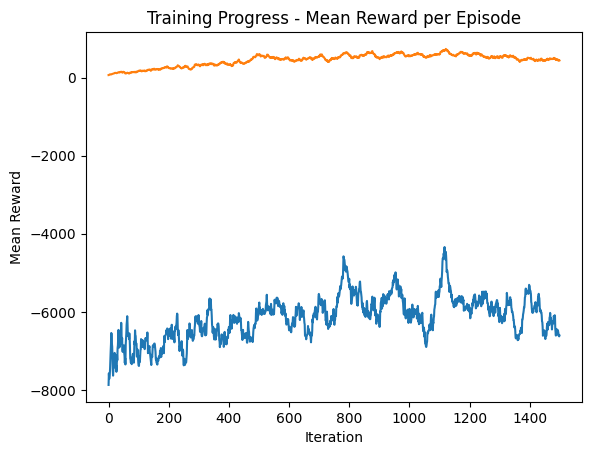

In [16]:
plt.plot(results)
plt.title('Training Progress - Mean Reward per Episode')
plt.xlabel('Iteration')
plt.ylabel('Mean Reward')
# plt.savefig('Basic PPO - HalfCheetah-v4')
plt.show()

CustomLossPolicy

In [66]:
# env = FlattenWaypointEnv(gym.make(id='PyFlyt/QuadX-Waypoints-v1', flight_mode=-1), context_length=1)

env = CustomDogfightEnv(config=env_config) 

obs_list = []
obs, info = env.reset()
# env.env.env.env.env.drones[0].set_mode(-1)
obs = obs
obs_list += [obs]

reward_list = []
action_list = []
start = time.time()
for i in range(10*40):
    # compute_action = algo.get_policy('policy_1').compute_actions(obs)
    # action = compute_action['default']
    # # obs, reward, terminated, truncated, info = env.step(np.zeros((4))+.79)
    # obs, reward, terminated, truncated, info = env.step(action)
    action_dict = {}
    for agent_id in obs:
        policy_id = 'policy_1' if agent_id == 'uav_0' else 'policy_2'
        input_dict = {
            "obs": torch.tensor([obs[agent_id]], dtype=torch.float32)  # Convert to tensor
        }
        compute_action = algo.get_policy(policy_id).compute_actions_from_input_dict(input_dict)
        action_dict[agent_id] = compute_action[0][0] 
        action_dict[agent_id] = np.clip(compute_action[0][0], -1.0, 1.0)  # Clip the action to valid range

    obs, reward, terminated, truncated, info = env.step(action_dict)


    
    obs_list += [obs]
    
    reward_list += [reward]
    action_list += [action_dict]
    
    if terminated["__all__"] or any(info[agent_id].get('collision', False) or info[agent_id].get('out_of_bounds', False) for agent_id in obs):
        break

arrays = np.array(obs_list)
obs_array = np.vstack(arrays)
reward_array = np.array(reward_list)
action_array = np.array(action_list) 
env.close()

In [68]:
obs_array.shape

(39, 1)

In [73]:
obs_array[20][0]

{'uav_0': array([ -2.73139659,   3.17285969,   0.82397661,  -1.04621234,
          0.8210868 ,  -1.81962768,  15.25568964,  -0.10148967,
          2.48659203, -37.58904101, -16.02275164,   9.5796757 ,
         -0.95288051,   0.95288051,   0.93549475,  -0.93549475,
          0.        ,   0.47870145,   1.        ,  -1.06630948,
          0.57454427,   0.68489792,   0.58236416,  -0.46233871,
          3.23366713, -17.39953515,   8.03617712, -11.14558912,
        -17.26403365,  34.79416912,  23.19130838,   1.        ,
         -0.95499879,   1.        ,  -0.3138684 ,   1.        ]),
 'uav_1': array([ -1.06630948,   0.57454427,   0.68489792,  -0.46384818,
          0.35874809,   1.41403945,  11.4408863 ,   3.31986146,
         -0.78626328,   4.98727516,  -0.7330717 ,   9.60857992,
         -0.72625316,   0.72625316,  -0.28900785,   0.28900785,
          0.        ,   0.36851621,   1.        ,  -2.73139659,
          3.17285969,   0.82397661,  -0.58236416,   0.46233871,
         -3.23366713

In [82]:
obs_array_uav_0 = np.array([obs['uav_0'] for obs in obs_list])
obs_array_uav_1 = np.array([obs['uav_1'] for obs in obs_list])

# Ensure the extracted array has the correct shape
obs_array_uav_0 = np.vstack(obs_array_uav_0)
obs_array_uav_1 = np.vstack(obs_array_uav_1)

In [90]:
scatter_uav_0 = go.Scatter3d(
    x=obs_array_uav_0[:, 10],
    y=obs_array_uav_0[:, 11],
    z=obs_array_uav_0[:, 12],
    mode='markers',
    marker=dict(
        size=5,
        color='red',
        opacity=0.6
    ),
    name='uav_0'
)
scatter_uav_1 = go.Scatter3d(
    x=obs_array_uav_1[:, 10],
    y=obs_array_uav_1[:, 11],
    z=obs_array_uav_1[:, 12],
    mode='markers',
    marker=dict(
        size=5,
        color='blue',
        opacity=0.6
    ),
    name='uav_1'
)
fig = go.Figure(data=[scatter_uav_0, scatter_uav_1])

# Save the plot as an HTML file
fig.write_html('3D_renders/3d_drone_space4_experiment.html')

In [ ]:
import seaborn as sns

In [ ]:
dataframes = {}
for filename in os.listdir(path+'/logs/test_runs'):
    if filename.endswith('.csv'):
        file_path = os.path.join(path+'/logs/test_runs', filename)
        df = pd.read_csv(file_path)
        key = os.path.splitext(filename)[0]
        dataframes[key] = df


data_list = []
labels = []
output_desired = 'length' #else will give length

for key, df in dataframes.items():
    if output_desired == 'reward':
        data_list.append(df.iloc[:,0])
        labels.append(f"reward for {key}")
    else:
        data_list.append(df.iloc[:,1])
        labels.append(f"length for {key}")

for data in data_list:
    sns.kdeplot(data, fill = True)

plt.legend(title = 'Modes', labels = labels)
plt.title(f"{output_desired}")
plt.show()

In [ ]:
dataframes = {}
for filename in os.listdir(path+'/logs/test_runs'):
    if filename.endswith('.csv'):
        file_path = os.path.join(path+'/logs/test_runs', filename)
        df = pd.read_csv(file_path)
        key = os.path.splitext(filename)[0]
        dataframes[key] = df


reward = []
labels = []
output_desired = 'reward' #else will give length

for key, df in dataframes.items():
    plt.scatter(df.iloc[:,0], df.iloc[:,1])
    labels.append(f"length for {key}")

plt.legend(title = 'Different runs', labels = labels)
plt.title(f"{output_desired} over time")
plt.show()